In [21]:
import os

# pip install kagglehub pandas numpy
import kagglehub
import pandas as pd
import numpy as np



# Loading the data

In [22]:
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\abdulhamed\.cache\kagglehub\datasets\uciml\electric-power-consumption-data-set\versions\1


Data is very big and memeory intensive so we will load it and make some memory optimaization and transformation then save it into parquet file which is faster, compresed and retains data types

In [23]:
filepath = os.path.join(path, "household_power_consumption.txt")


cols_to_load = ['Date','Time','Global_active_power','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Build dtype map for float32, excluding Date and Time
dtype_map = {col: 'float32' for col in cols_to_load if col not in ['Date','Time']}

loaded_df = pd.read_csv(
    filepath,
    usecols=cols_to_load,
    sep=';',
    na_values=['?'],
    dtype=dtype_map,
    engine='c',
    low_memory=False  # Avoid dtype guessing in chunks

)
loaded_df['datetime'] = pd.to_datetime(
loaded_df['Date'] + ' ' + loaded_df['Time'],  # Combine columns
dayfirst=True)                    # European format (DD/MM/YYYY)
loaded_df = loaded_df.set_index('datetime').drop(['Date', 'Time'], axis=1)

print(f"Memory usage: {loaded_df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print()
print('data types: ', loaded_df.dtypes)


Memory usage: 49.81 MB

data types:  Global_active_power    float32
Sub_metering_1         float32
Sub_metering_2         float32
Sub_metering_3         float32
dtype: object


In [24]:
loaded_df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,
2006-12-16 17:24:00,4.216,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.0,1.0,17.0


## Selected Variables Overview

We are focusing on the following variables from the dataset:

* **`global_active_power`**: Total real power consumed by the household (in kW) per minute. This represents the *sum* of all devices, including those covered by sub-meters and others.
* **`sub_metering_1`**: Energy consumption per minute in the kitchen area (dishwasher, oven, microwave) (in Wh).
* **`sub_metering_2`**: Energy consumption per minute in the laundry room (washer, dryer, fridge) (in Wh).
* **`sub_metering_3`**: Energy consumption per minute by the water heater and air conditioner (in Wh).

We have excluded `global_reactive_power`, `voltage`, and `global_intensity` for this analysis based on the understanding that `global_active_power` is the primary focus for energy consumption and billing, and the other variables are either less relevant for appliance-level analysis or mathematically related to active power.

---

### 1. **Understanding Your IoT Energy Consumption Data**

You have:

* **Minute-level samples** of energy usage.
* **3 columns in Wh (watt-hours)**
* **1 column in kW (kilowatts)**

Let’s break this down:

* **Wh (Watt-hour)**: Measures **energy**, i.e., how much power was used over time.
  → If a device uses 100 watts for 1 hour, it consumes 100 Wh.

* **kW (Kilowatt)**: Measures **power**, i.e., the rate at which energy is used **at a moment in time**.
  → 1 kW = 1000 watts.

* **kW per minute** is unusual terminology. Likely, this column is **instantaneous power in kW measured every minute**.

---

### 2. **Should You Average or Sum When Resampling to Hourly?**

#### For **Wh columns**:

* tells us how much energy is consumed (or produced) over a period of time.
* Each sample represents **energy consumed in that minute**, so:

  * **Sum them** over the hour → gives total energy consumed in that hour.

#### For **kW column**:

* Each sample is **instantaneous power**, typically measured at the minute.
* It represents the amount of power used at a specific moment in time.

  * **Average them** over the hour → gives **mean power** used in that hour.

#### Based on Data:

| datetime            | Global\_active\_power | Sub\_metering\_1 | Sub\_metering\_2 | Sub\_metering\_3 |
| ------------------- | --------------------- | ---------------- | ---------------- | ---------------- |
| 2006-12-16 17:24:00 | 4.216 (kW)            | 0.0 (Wh)         | 1.0 (Wh)         | 17.0 (Wh)        |
| 2006-12-16 17:25:00 | 5.36                  | 0.0              | 1.0              | 16.0             |
| 2006-12-16 17:26:00 | 5.374                 | 0.0              | 2.0              | 17.0             |

Let’s interpret:

* **`Global_active_power`** is in **kW** — it’s **instantaneous power** (at the minute).
* **`Sub_metering_X`** columns are in **Wh** — **energy consumed during that minute** for different appliances.

---

### 3. **Energy vs. Power: How to Understand Your Data**

Now that you understand the differences between **kW** (power) and **Wh** (energy), let’s clarify how to think about these units in the context of your dataset.

* **Power (kW)** tells you the **rate** of energy consumption at any given moment (per minute in your data).
* **Energy (Wh)** tells you how much total energy has been used over a period of time (per minute in your data).

Because your **sub-metering values are already in Wh** (energy per minute), **you sum** these values over an hour to get the **total energy consumed** in that hour.

For example:

* If `sub_metering_1` shows **0.8 Wh** at 12:01, it means **0.8 Wh of energy** was used during **the minute between 12:00-12:01**.
* If you sum the `sub_metering_1` values over an hour (i.e., sum of the 60-minute samples), you’ll get **total energy consumption for that hour**.

On the other hand, the **Global\_active\_power** in **kW** gives the **rate of power consumption** at each minute, so to get the **average power** over an hour, you **average** the values over the 60 minutes.
Here’s the summarized section rewritten with LaTeX instead of Python code:

---

### 4. **Unmetered Energy (`other_consumption`)**

We estimate the energy used by devices **not tracked by the three sub-meters** using:

$$
\text{other\_consumption} = \left( \frac{\text{Global\_active\_power} \times 1000}{60} \right) - \left( \text{Sub\_metering\_1} + \text{Sub\_metering\_2} + \text{Sub\_metering\_3} \right)
$$

* `Global_active_power` is in **kW**, so we convert it to **Wh per minute** by multiplying by 1000 and dividing by 60.
* We subtract the sum of the three sub-meter readings (already in Wh) to isolate **unaccounted consumption**.
* Any negative results (due to noise or rounding) are clipped to zero:

$$
\text{other\_consumption} = \max(0,\ \text{other\_consumption})
$$

This value reflects the **energy used by appliances not captured by the sub-metered channels**, such as lighting, electronics, or small kitchen devices.




In [25]:
# changing Global_active_power to be in W instead of KW
loaded_df['Global_active_power'] = loaded_df['Global_active_power'] * 1000

loaded_df['other_consumption'] = (loaded_df['Global_active_power'] / 60) - (
                loaded_df['Sub_metering_1'] + loaded_df['Sub_metering_2'] + loaded_df['Sub_metering_3'])

loaded_df['other_consumption'] = loaded_df['other_consumption'].clip(lower=0)


In [26]:
# 2. Resample to hourly
df_hourly = loaded_df.resample('h').agg({
    'Global_active_power': 'mean',  # average power (W)
    'Sub_metering_1': 'sum',        # total energy (Wh)
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'other_consumption': 'sum'
})

df_hourly.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,other_consumption
datetime,,,,,
2006-12-16 17:00:00,4222.888672,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,3632.199951,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,3400.233398,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,3268.566650,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,3056.466553,0.0,25.0,1033.0,1998.466675


In [27]:
# print date years range
print("Date range:", df_hourly.index.min().date(), "to", df_hourly.index.max().date())

Date range: 2006-12-16 to 2010-11-26


# get exgo weather data


In [54]:
def fetch_weather_data(start, end):
    import requests_cache
    import pandas as pd

    # Convert to datetime if not already
    if isinstance(start, str):
        start = pd.to_datetime(start)
    if isinstance(end, str):
        end = pd.to_datetime(end)

    # Setup caching session with retries
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    # You can add retry logic here or use requests_retry_session if you want

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 48.7762,
        "longitude": 2.2905,
        "start_date": start.strftime("%Y-%m-%d"),
        "end_date": end.strftime("%Y-%m-%d"),
        "hourly": "temperature_2m,relative_humidity_2m",
        "timezone": "Europe/Paris"
    }

    response = cache_session.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract hourly data
    hourly = data.get('hourly', {})
    times = hourly.get('time', [])
    temperature = hourly.get('temperature_2m', [])
    humidity = hourly.get('relative_humidity_2m', [])

    if not times or not temperature or not humidity:
        raise ValueError("Missing data in weather API response")

    # Convert times to datetime index, handle DST gaps and ambiguous times (DST end)
    times_dt = pd.to_datetime(times).tz_localize('Europe/Paris', ambiguous='NaT', nonexistent='shift_forward').tz_convert(None)  # naive local time

    weather_df = pd.DataFrame({
        'temperature_2m': temperature,
        'relative_humidity_2m': humidity
    }, index=times_dt)
    weather_df.index.name = 'date'

    return weather_df

# Create DataFrame
weather_data = fetch_weather_data('2006-12-16', '2011-1-1')

In [55]:
print(weather_data.isna().sum())
print(weather_data.duplicated().count())
weather_data.head()

temperature_2m          0
relative_humidity_2m    0
dtype: int64
35472


,temperature_2m,relative_humidity_2m
date,,
2006-12-15 23:00:00,5.4,91
2006-12-16 00:00:00,5.3,92
2006-12-16 01:00:00,5.1,93
2006-12-16 02:00:00,5.1,93
2006-12-16 03:00:00,5.3,94


In [ ]:
# Remove duplicate timestamps by aggregating (e.g., mean)
weather_data = weather_data.groupby(weather_data.index).mean()

In [60]:
print(weather_data.index.min(), weather_data.index.max())

2006-12-15 23:00:00 2011-01-01 22:00:00


In [58]:
weather_data.to_csv("Sceaux_hourly_weather_2006_2010.csv")

# Some Cleaning
if we dropped the NaN we will get time gaps which will result in bad results at the end so we will impute the missing data by **interpolate** it (for power data "smooth transitions").

In [29]:
# Generate expected hourly timestamps
expected_hours = pd.date_range(
    start=df_hourly.index.min(), 
    end=df_hourly.index.max(), 
    freq='h'  # Ensure hourly frequency
)

# Check for missing hours
missing_hours = expected_hours.difference(df_hourly.index)
print(f"Missing hours: {len(missing_hours)}")

Missing hours: 0


No time gaps, very good

In [30]:
print(f"Data shape: {df_hourly.shape}")
print(f"Number of NaN values:\n{df_hourly.isna().sum()}")

Data shape: (34589, 5)
Number of NaN values:
Global_active_power    421
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
other_consumption        0
dtype: int64


In [31]:
# impute missing values in Global_active_power
df_hourly['Global_active_power'] = df_hourly['Global_active_power'].interpolate(method='time')
print(f"Number of NaN values:\n{df_hourly.isna().sum()}")

Number of NaN values:
Global_active_power    0
Sub_metering_1         0
Sub_metering_2         0
Sub_metering_3         0
other_consumption      0
dtype: int64


## Examine Date fro Outlier Handling
we need to see if the data is skewd (result from spikes and means extreme values), zero infelation, and see the box plot for the data
> make a box plot and histogram for each column

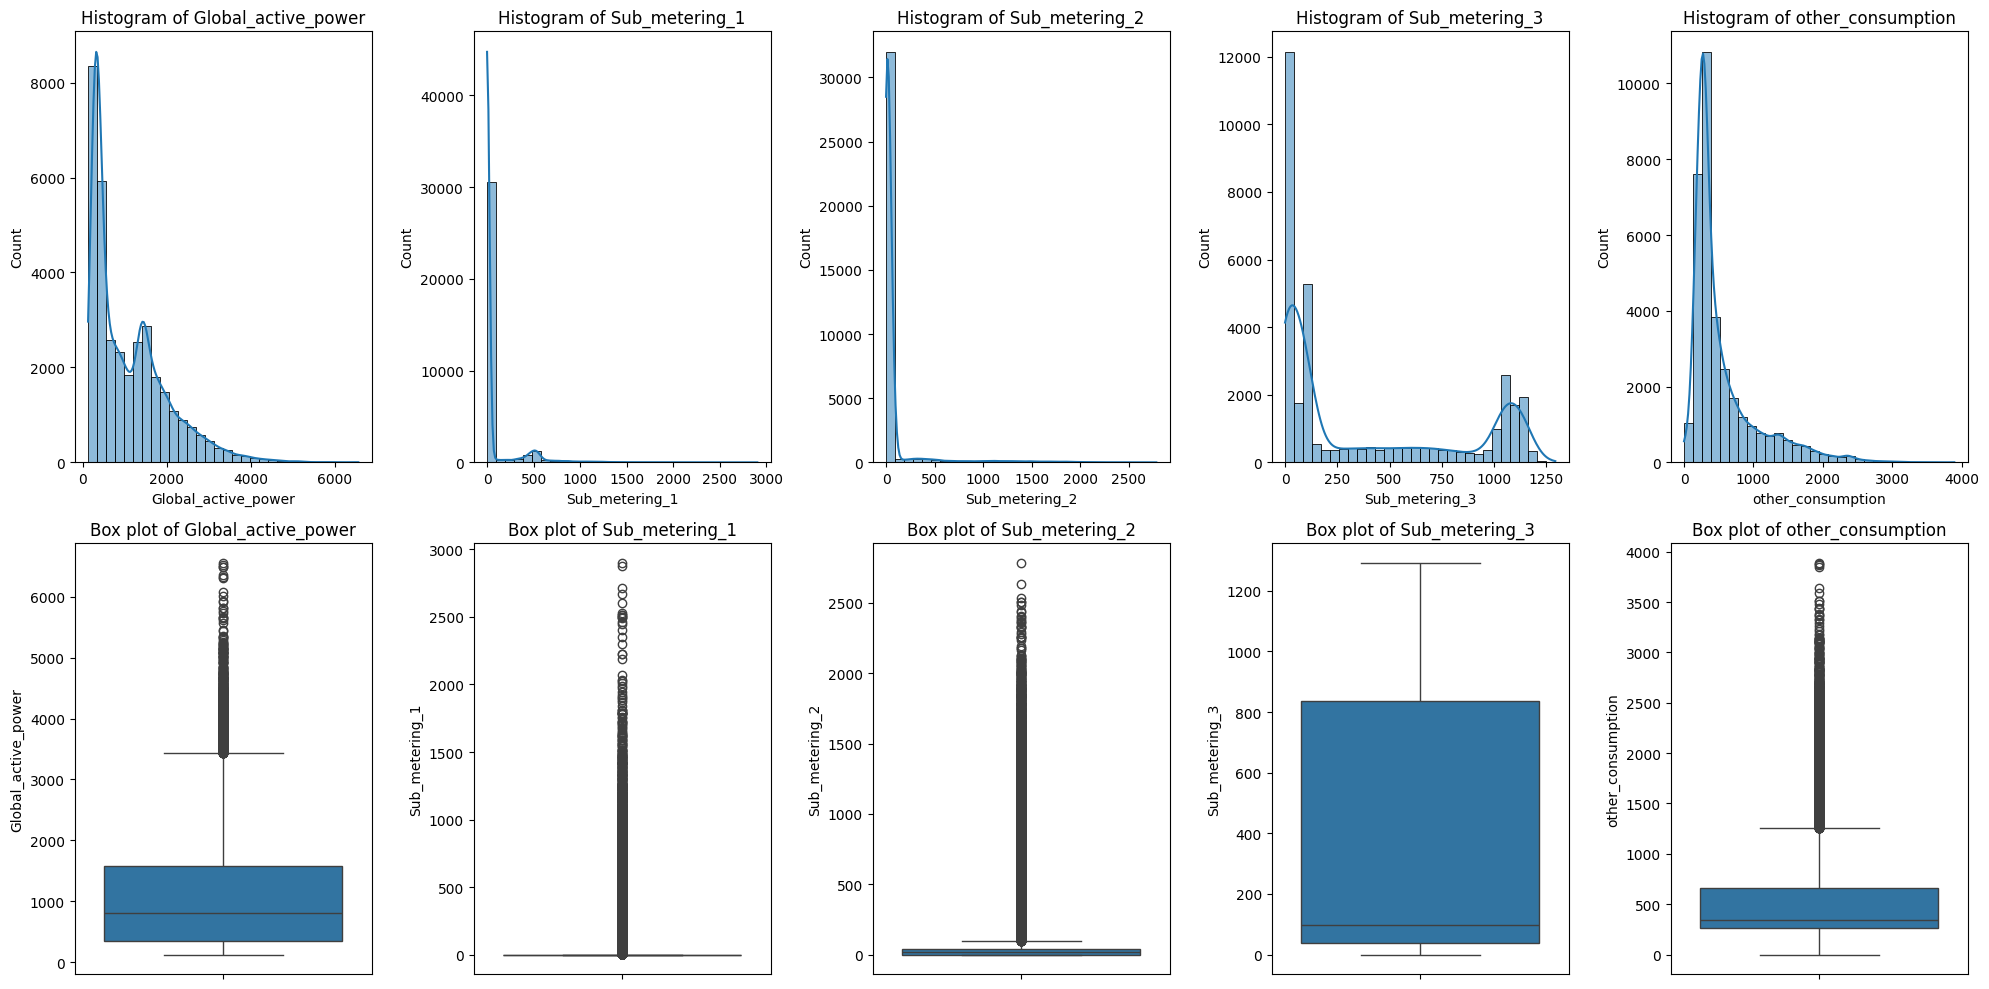

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box_hist(df:pd.DataFrame):
    # Create a figure with 2 rows and 5 columns (one for each column in df_hourly)
    _, axes = plt.subplots(2, len(df.columns), figsize=(20, 10))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot histograms in the first row
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')

    # Plot boxplots in the second row
    for i, col in enumerate(df.columns):
        sns.boxplot(y=df[col], ax=axes[i + len(df.columns)])
        axes[i + len(df.columns)].set_title(f'Box plot of {col}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_box_hist(df_hourly)

#### We can see that the data is highly skewed right and the meterings 1,2,3 have zero infelations

- Right skew means extreme values are high (not low). Outliers here are extremely high power draws.
    * Detection: Use Percentiles: Avoid Z-scores (assumes normality).
    * Log Transformation (for visualization)
    * Handling: Winsorizing (Capping): Replace values above the upper_limit with the upper_limit value (using this we will not need to remove values so we can't get time gaps).
    * Robust Scaling (if using ML models)
- Zero-Inflated Sub-Metering (e.g., Sub_metering_1)
    * Zeros might represent valid inactivity (e.g., dishwasher off) or sensor errors.





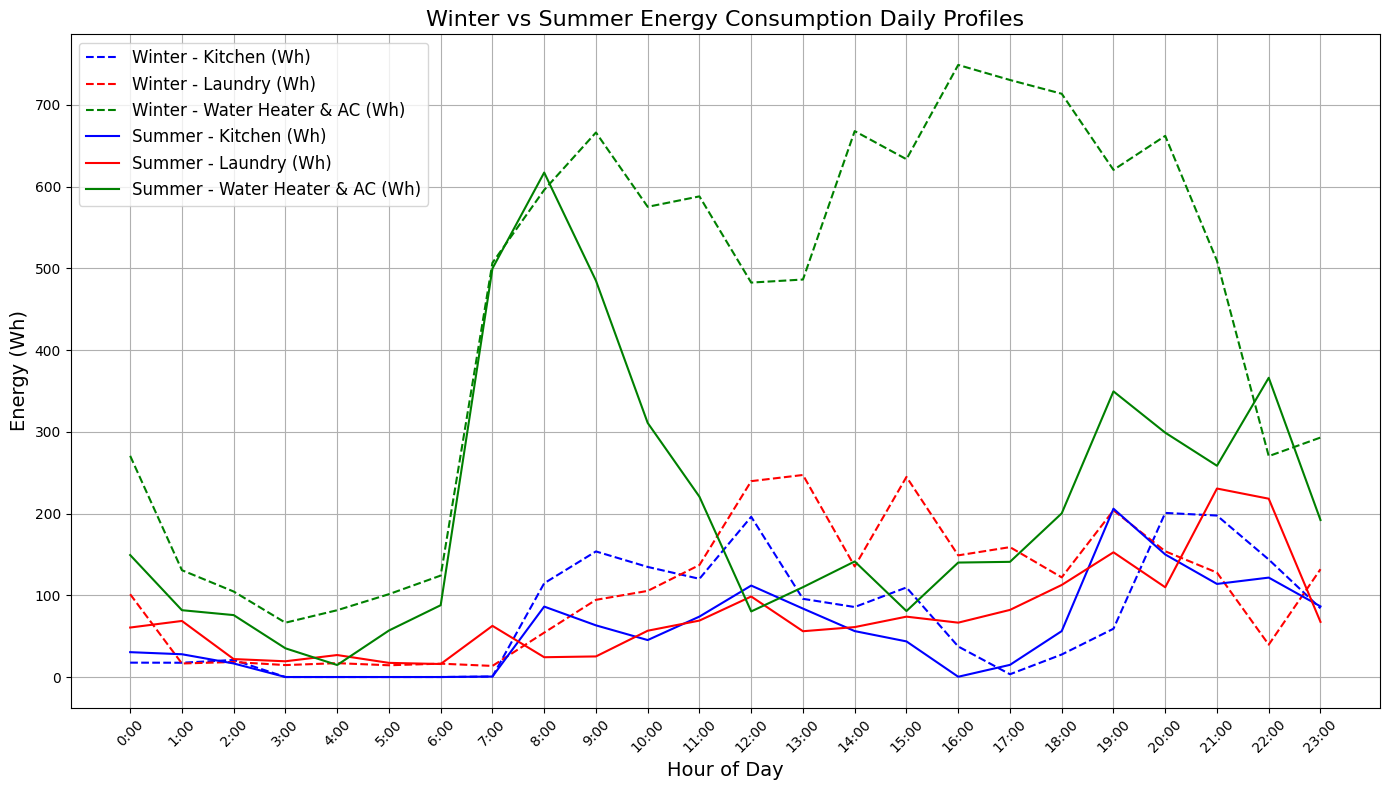

In [33]:
import matplotlib.pyplot as plt

# Example: Analyze January 2007 (winter) and July 2007 (summer)
winter_data = df_hourly.loc['2007-01-01':'2007-01-31']
summer_data = df_hourly.loc['2007-07-01':'2007-07-31']
winter_daily_profile = winter_data.groupby(winter_data.index.hour).mean()
summer_daily_profile = summer_data.groupby(summer_data.index.hour).mean()
# Plot winter and summer daily profiles for the 3 submeters
plt.figure(figsize=(14, 8))

# Winter
plt.plot(winter_daily_profile.index, winter_daily_profile['Sub_metering_1'], label='Winter - Kitchen (Wh)', color='blue', linestyle='--')
plt.plot(winter_daily_profile.index, winter_daily_profile['Sub_metering_2'], label='Winter - Laundry (Wh)', color='red', linestyle='--')
plt.plot(winter_daily_profile.index, winter_daily_profile['Sub_metering_3'], label='Winter - Water Heater & AC (Wh)', color='green', linestyle='--')

# Summer
plt.plot(summer_daily_profile.index, summer_daily_profile['Sub_metering_1'], label='Summer - Kitchen (Wh)', color='blue')
plt.plot(summer_daily_profile.index, summer_daily_profile['Sub_metering_2'], label='Summer - Laundry (Wh)', color='red')
plt.plot(summer_daily_profile.index, summer_daily_profile['Sub_metering_3'], label='Summer - Water Heater & AC (Wh)', color='green')

# Customize plot
plt.title('Winter vs Summer Energy Consumption Daily Profiles', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Energy (Wh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(0, 24), labels=[f'{h}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

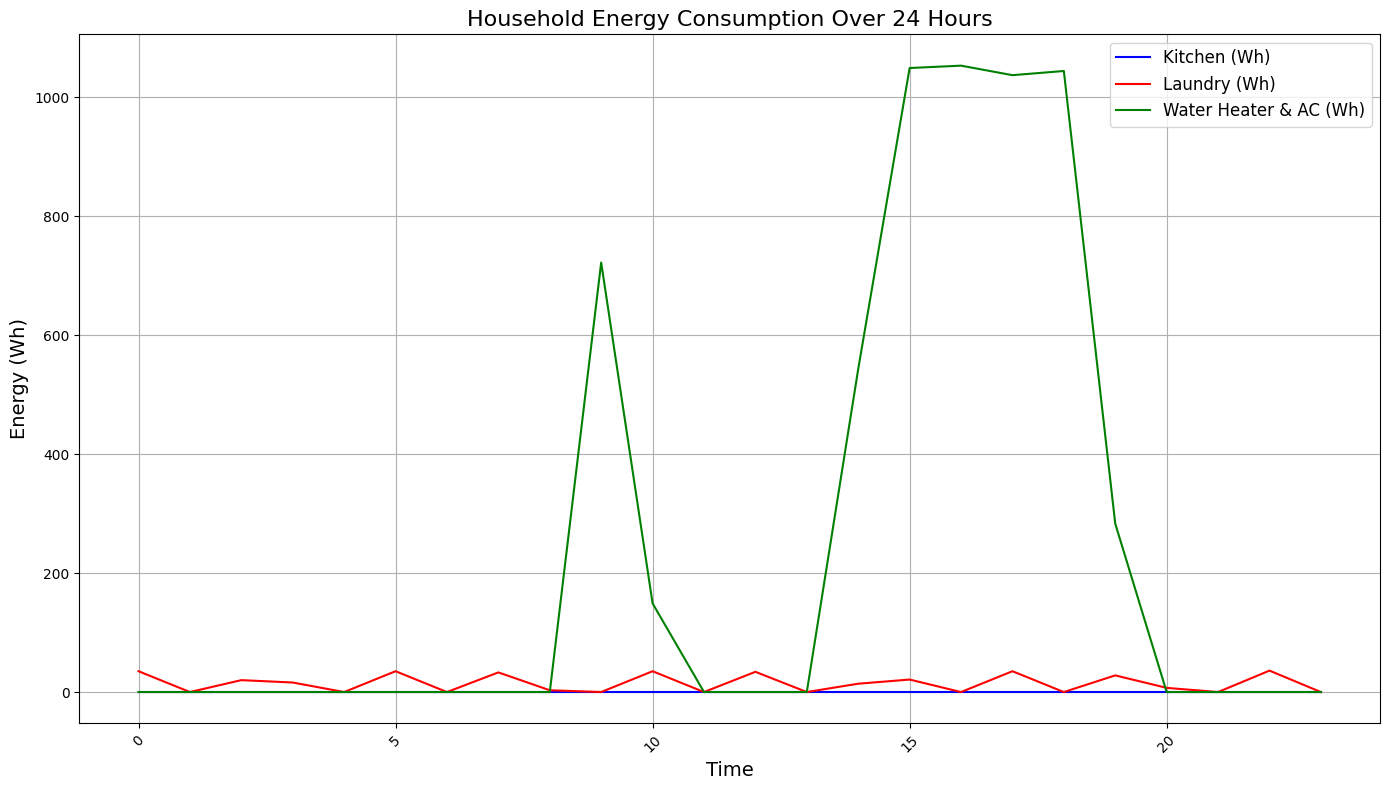

In [34]:
one_day = df_hourly.loc['2007-01-1']

# Plot each submeter
plt.figure(figsize=(14, 8))
plt.plot(one_day.index.hour, one_day['Sub_metering_1'], label='Kitchen (Wh)', color='blue')
plt.plot(one_day.index.hour, one_day['Sub_metering_2'], label='Laundry (Wh)', color='red')
plt.plot(one_day.index.hour, one_day['Sub_metering_3'], label='Water Heater & AC (Wh)', color='green')

# Customize plot
plt.title('Household Energy Consumption Over 24 Hours', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy (Wh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ploting 1 day profile show us
1. laundary have 1 hour cycle on and off which could be the fridge and by examining other days we can see high increase in usage after 15:00 to almost 22:00
2. water heater & AC have some spikes over the day centered around 8:00 and 20:00 with a 4 hour range (e.g. 6:00 - 8 - 10:00) if we saw the mean over the year for 1 day and lowes values centerd at 3:00, but hour 15 and around it is low at summer but very high at winter
3. Ketchen usualy have  between 18:00 and 24:00 and less spikes between 8:00 and 15:00 from the full year aggrigation

### **Outlier Handling Aligned with Daily/Seasonal Patterns**  
Given the observed daily and seasonal profiles of your submetered data, outlier detection must account for **time-dependent expected behavior**. Here’s how to handle outliers for each appliance category:
#### **1. Laundry Room (`Sub_metering_2`)**
**Observed Pattern**:  
- **Fridge**: 1-hour on/off cycles (normal).  
- **Increased Usage (15:00–22:00)**: Likely washer/dryer activity.  

**Outlier Detection**:  
- **Fridge Cycling Zeros**:  
  - **Valid**: Zeros lasting ≤1 hour (normal compressor off-cycles).  
  - **Invalid**: Zeros >1 hour during 15:00–22:00 (e.g., washer/dryer malfunction).  
- **Spikes**:  
  - Flag values >99th percentile during 15:00–22:00.  

#### **2. Water Heater & AC (`Sub_metering_3`)**
**Observed Pattern**:  
- **Spikes**: Centered around 8:00 and 20:00 (±2 hours).  
- **Seasonality**: High usage in winter at 15:00, low in summer.  

**Outlier Detection**:  
- **Winter**: Flag values >95th percentile between 14:00–16:00.  
- **Summer**: Flag values >95th percentile between 6:00–10:00 and 18:00–22:00.  

#### **3. Kitchen (`Sub_metering_1`)**
**Observed Pattern**:  
- **Peak**: 18:00–24:00 (meal prep).  
- **Low Activity**: 8:00–15:00.  

**Outlier Detection**:  
- **Suspicious Zeros**: During 18:00–24:00 (oven/dishwasher should be active).  
- **Spikes**: Values >95th percentile outside 18:00–24:00.  

#### **Key Takeaways**
- **Time-Aware Capping**: Use percentile thresholds **specific to usage windows** (e.g., laundry hours).  
- **Seasonal Adjustments**: Separate rules for winter/summer (critical for AC/water heater).  
- **Contextual Zero Handling**: Treat zeros as valid/invalid based on **appliance behavior**.  

By aligning outlier handling with observed temporal patterns, you preserve **meaningful signals** while removing noise.
### but for the sake of simplicity i will just cap what is over 90% in all columns that is for the spikes

In [35]:
# how many above the 90%
df_hourly.where(df_hourly > df_hourly.quantile(0.90)).count()


Global_active_power    3459
Sub_metering_1         3459
Sub_metering_2         3368
Sub_metering_3         3422
other_consumption      3459
dtype: int64

In [36]:
upper_limit = df_hourly.quantile(0.90)
# Winsorizing (Capping)
df_capped = df_hourly.clip(upper=upper_limit, axis=1)
df_capped.max()

Global_active_power    2347.320020
Sub_metering_1          310.200000
Sub_metering_2           72.000000
Sub_metering_3         1090.000000
other_consumption      1300.480005
dtype: float64

# Finish and Export Data for future steps

In [37]:
# Save the cleaned and processed dataset to a Parquet file
df_capped.to_parquet("ETL_data.parquet", engine='pyarrow', index=True)

print(f"Dataset saved")

Dataset saved
